## Exploratory Data Analysis - Xtern Work Sample Assessment

### Table of Contents
- [Description of the task](#task-description)
- [Reading in data](#reading-data)
- [Basic EDA](#basic-info)
- [Clustering on locations](#clustering-on-locations)
- [Analysis on charging time](#analysis-on-charging-time)
- [Most popular location](#most-popular-location)
- [Operation cost](#operation-cost)
- [Final conclusion](#final-conclusions)

<a id="task-description"></a>
### Description of the task

Have you ever hopped on a scooter and realized the battery is dead? 😣 What an upsetting experience! 

In order to prevent that horrible user experience from happening, the data science team is focusing its efforts on coming up with the best scooter charging strategy. 

You can find a data set below with scooters’ current geolocation and power level. Power level ranges from 0 - 5 (0 as completely out of battery, 5 as fully charged). It takes 5 hours to charge a scooter’s power from 0 to 5. TechPointX talent team also has a mega charging bus that drives around to pick up scooters and charge them inside. Unfortunately, the bus can only park and start at location 20.19 (xcoordinate), 20.19 (ycoordinate) and only travel 50 miles per hour. 

**Task**:

Review the data set, and draw any conclusions you can find from the data set. Try to identify the most popular scooter location, demonstrate your findings using data visualization tools, calculate operation time cost (Operation Time Cost: How long it takes to fully charge all the scooters), and come up with the most efficient scooter charging strategy. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set()

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

<a id="reading-data"></a>
### Reading in the data

In [2]:
data = pd.read_csv("2019-XTern- Work Sample Assessment Data Science-DS.csv")

In [3]:
data.head()

,scooter_id,xcoordinate,ycoordinate,power_level
0,0,0.906835,0.776484,0
1,1,0.928587,0.804964,2
2,2,0.904091,0.784043,1
3,3,0.906752,0.804461,0
4,4,0.900641,0.781683,4


<a id="basic-info"></a>
### Basic EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25668 entries, 0 to 25667
Data columns (total 4 columns):
scooter_id     25668 non-null int64
xcoordinate    25668 non-null float64
ycoordinate    25668 non-null float64
power_level    25668 non-null int64
dtypes: float64(2), int64(2)
memory usage: 802.2 KB


In [5]:
data.shape

(25668, 4)

In [6]:
data.scooter_id.nunique()

25668

All the scooter id's are unique in nature. And we have one row in the dataset for each scooter.

### Distribution of the Power level of the scooter

Text(0.5, 1.0, 'Count of scooters by power levels')

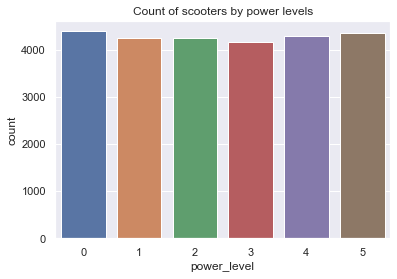

In [7]:
sns.countplot(data=data, x="power_level")
plt.title("Count of scooters by power levels")

The dataset has a even distribution in terms of power level. It is not biased towards any particular power level.

### Location of the scooters

Text(0, 0.5, 'Y-Coordinate')

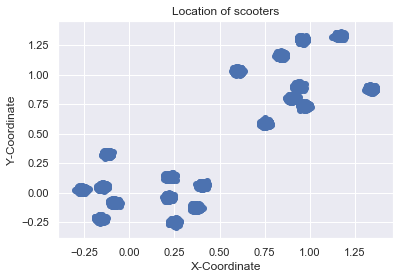

In [8]:
plt.scatter(x="xcoordinate", y="ycoordinate", data=data)
plt.title("Location of scooters")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")

We can visually see that the location of the scooters form 3 clusters.

<a id="clustering-on-locations"></a>
### Clustering on locations

Although there are 19 small clusters, instead of treating them as individual clusters, K-Means has been used to identify cluster centers.

In [9]:
from sklearn.cluster import KMeans
locations = data[["xcoordinate","ycoordinate"]].to_numpy()

Text(0, 0.5, 'Error Loss')

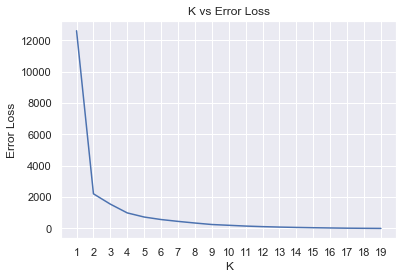

In [10]:
error_loss =[] 
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, max_iter = 500) 
    kmeans.fit(locations) 
    error_loss.append(kmeans.inertia_) 
    
plt.plot(range(1, 20), error_loss) 
plt.xticks(np.arange(1,20, step=1))
plt.title("K vs Error Loss")
plt.xlabel("K") 
plt.ylabel("Error Loss") 

After 4, the error kind of smoothens out. So we can take the number of clusters to be 4.

In [11]:
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, max_iter = 500) 
kmeans.fit(locations)
data['cluster_number'] = kmeans.labels_

Text(0, 0.5, 'Y-Coordinate')

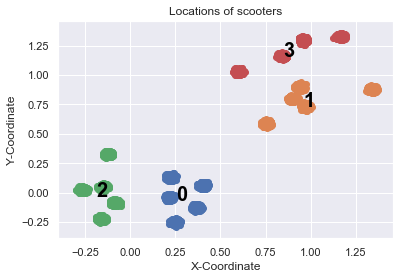

In [12]:
for label in range(0, n_clusters):

    #data points
    plt.scatter(x=data.loc[data['cluster_number']==label, 'xcoordinate'], 
                y=data.loc[data['cluster_number']==label,'ycoordinate'])
    
    #labels
    plt.annotate(label, 
                 data.loc[data['cluster_number']==label,['xcoordinate','ycoordinate']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='black') 
plt.title("Locations of scooters")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")

<a id="analysis-on-charging-time"></a>
### Analysis on charging time

#### Charging time - all scooters

In [13]:
data["hours_of_charging_required"] = 5 - data["power_level"]
data[["hours_of_charging_required", "cluster_number"]].groupby("cluster_number").sum()

,hours_of_charging_required
cluster_number,
0,19631
1,17711
2,14699
3,12230


So, just for **cluster 0**, it would take **19631 hours** to charge all the scooters to their full capacity. This is with the assumption that scooters are charged one after the other. However, since TechPointX talent team has a mega charging bus, they can do this in batches. Even if the bus **can accomodate 1000 scooters at a time**, even then it is going to take **~ 20 hours** to fully charge the scooters. That is a lot of time, and hence we would need to make some assumptions and tradeoffs.

In [14]:
data["hours_of_charging_required"].sum()/1000

64.271

And the total number of hours required to charge all the scooters back to their full potential is ~ 64 hours.

#### Which bikes to charge?

Time required to charge all scooters having power level <= 1 : 38.932 hours
Time required to charge all scooters having power level <= 2 : 51.667 hours
Time required to charge all scooters having power level <= 3 : 59.987 hours
Time required to charge all scooters having power level <= 4 : 64.271 hours


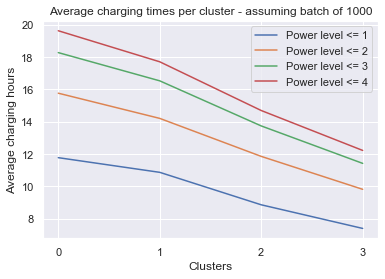

In [15]:
for power_level in range(1,5):
    charging_hours_per_cluster = data[data.power_level <= power_level][["hours_of_charging_required", "cluster_number"]].groupby("cluster_number").sum()/1000
    print("Time required to charge all scooters having power level <= {} : {} hours".format(power_level,charging_hours_per_cluster["hours_of_charging_required"].sum()))
    plt.plot(charging_hours_per_cluster, label="Power level <= {}".format(power_level))
plt.xlabel("Clusters")
plt.xticks(np.arange(0,n_clusters,1))
plt.ylabel("Average charging hours")
plt.title("Average charging times per cluster - assuming batch of 1000")
plt.legend()

- The following conclusions can be drawn from the analysis:
    - Time required to charge all scooters having power level <= 1 ~ 39 hours
    - Time required to charge all scooters having power level <= 2 ~ 52 hours
    - Time required to charge all scooters having power level <= 3 ~ 60 hours
    - Time required to charge all scooters having power level <= 4 ~ 64 hours

#### Charging time - Assumptions and Tradeoffs

**Assumptions**
- A given scooter has 5 power levels, and it takes 5 hours to charge a scooter completely. So, it can be assumed that the relationship between power level and charging time is linear. In other words, after charging for one hour, the power level of a scooter increases by 1.
- The rate of expenditure of power of a scooter is slower than the charging rate. So, a power level of 1 means that the scooter would not run out of battery before 1 hour.

**Trade Offs**
- *Do we need to charge all the scooters?* 
    - If a scooter has zero charge, then it is obviously unusuable. However, if the scooter has charge 1 or charge 2, it is usable but a consumer may think twice before using it. The probability that the scooter runs out of battery while in use is high.
    - On the other hand, if a scooter has charge 3,4 or 5, a consumer would easily take the scooter since the probability that it would run out of battery while in use is low.
    - By compromising charging all the scooters, the bus can focus on making lives easier for the consumers by making sure most of the scooters are in a usable condition.

**Assumption: The bus will only charge the scooters that are presently at charge levels 0,1 and 2.**

- Do we need to charge these scooters to their full extent?
    - Charging one scooter to its full capacity takes 5 hours. Maybe the bus can charge scooters halfway through instead of charging them all the way. This would enable it to service more consumers.
    - By compromising on charging the scooters all the way up, the bus can focus on maximising the number of scooters that the consumers can use.
    
**Assumption: The bus will charge the scooters halfway through.**

#### Are there clusters that we can skip?

In [16]:
scooters_needing_charging = data[data.power_level <= 2]

Text(0, 0.5, 'Y-Coordinate')

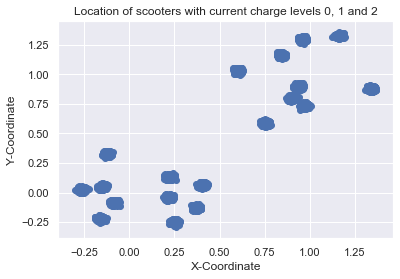

In [17]:
plt.scatter(x="xcoordinate", y="ycoordinate", data = scooters_needing_charging)
plt.title("Location of scooters with current charge levels 0, 1 and 2")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")

All of the clusters have scooters that require charging, so we won't need to visit every cluster.

#### Charging times - with the tradeoffs

In [18]:
data_power_level_less_than_three = data[data.power_level <= 2][["scooter_id", "xcoordinate", "ycoordinate", "power_level", "cluster_number"]]
data_power_level_less_than_three["hours_of_charging_required_to_reach_level_3"] = 3-data_power_level_less_than_three["power_level"]

In [19]:
data_power_level_less_than_three.head()

,scooter_id,xcoordinate,ycoordinate,power_level,cluster_number,hours_of_charging_required_to_reach_level_3
0,0,0.906835,0.776484,0,1,3
1,1,0.928587,0.804964,2,1,1
2,2,0.904091,0.784043,1,1,2
3,3,0.906752,0.804461,0,1,3
5,5,0.899680,0.790893,2,1,1


In [20]:
overall_charging_time = 0
for cluster in range(0,n_clusters):
    power_level_less_than_three_by_cluster = data_power_level_less_than_three[data_power_level_less_than_three.cluster_number == cluster]
    agg_power_level_data = power_level_less_than_three_by_cluster[["hours_of_charging_required_to_reach_level_3", "scooter_id"]].groupby(["hours_of_charging_required_to_reach_level_3"]).count()
    agg_power_level_data.reset_index(inplace=True)
    total_charging_hours_in_cluster = agg_power_level_data.apply(lambda y: y['hours_of_charging_required_to_reach_level_3'] * y['scooter_id'], axis=1).sum()
    overall_charging_time += total_charging_hours_in_cluster
    print("Cluster: {}, Total charging hours in cluster: {}".format(cluster, total_charging_hours_in_cluster))
print("Overall charging time: {}".format(overall_charging_time))

Cluster: 0, Total charging hours in cluster: 7875
Cluster: 1, Total charging hours in cluster: 7187
Cluster: 2, Total charging hours in cluster: 5924
Cluster: 3, Total charging hours in cluster: 4919
Overall charging time: 25905


So, with the tradeoffs, it would require around ~25 hours to charge the scooters, which is half of the previous estimate.

<a id="most-popular-location"></a>
### Most popular location

The definition of most popular location is quite ambiguous. Here are some of the possible definitions:
    
A location can be thought of to be the most popular if:
- it has the most number of scooters available.
- it has the most number of discharged scooters available.
- it has the least number of fully charged scooters.
    - The presence of charged scooters can be a sign of inactivity.
- the ratio of fully charges to charged scooters is highest.
- the ratio of number of scooters to number of people living in the area is the highest.

We will explore some of these definitions.

#### Number of scooters available

Text(0.5, 1.0, 'Number of scooters in each cluster')

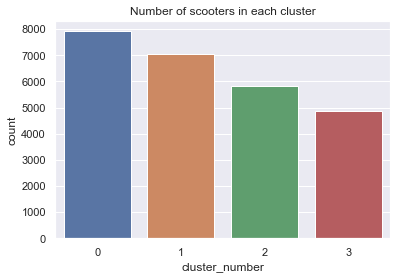

In [21]:
sns.countplot(x="cluster_number", data=data)
plt.title("Number of scooters in each cluster")

According to this definition, cluster 0 seems to be the most popular, while cluster 3 seems to be the least popular.

#### Number of discharged scooters

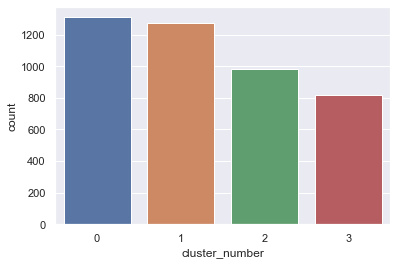

In [22]:
sns.countplot(x="cluster_number", data=data[(data.power_level == 0)])

According to this definition too, cluster 0 seems to be the most popular. However, from this graph and the previous one, it is evident that the ratio of discharged scooters to total scooters is greater in cluster 1 than cluster 0. We can verify the same by explicitly computing the ratio and plotting the same.

#### Ratio of charged to discharged scooters

Text(0.5, 1.0, 'Ratio of discharged scooters to total scooters present per cluster')

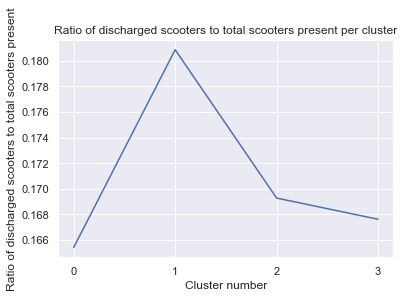

In [23]:
scooters_per_cluster = data[["scooter_id","cluster_number"]].groupby("cluster_number").count()
scooters_per_cluster.reset_index(inplace=True)
scooters_per_cluster.rename(columns= {"scooter_id": "count_of_scooters"}, inplace=True)

discharged_scooters_per_cluster = data[data.power_level == 0][["scooter_id","cluster_number"]].groupby("cluster_number").count()
discharged_scooters_per_cluster.reset_index(inplace=True)
discharged_scooters_per_cluster.rename(columns= {"scooter_id": "count_of_discharged_scooters"}, inplace=True)

total_and_discharged_scooters = scooters_per_cluster.join(discharged_scooters_per_cluster.set_index("cluster_number"), on="cluster_number")
total_and_discharged_scooters['activity_indicator'] = total_and_discharged_scooters.apply(lambda x: x['count_of_discharged_scooters']/x['count_of_scooters'], axis=1)

plt.plot(total_and_discharged_scooters['activity_indicator'])
plt.xticks(np.arange(0, n_clusters,1))
plt.xlabel("Cluster number")
plt.ylabel("Ratio of discharged scooters to total scooters present")
plt.title("Ratio of discharged scooters to total scooters present per cluster")

So, by this definition of popularity, cluster 1 is the most popular location.

#### Number of fully charged scooters

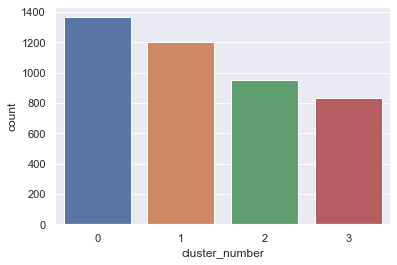

In [24]:
sns.countplot(x="cluster_number", data=data[(data.power_level == 5)])

#### Ratio of fully charged scooters to total number of scooters

Text(0.5, 1.0, 'Ratio of charged scooters to total scooters present per cluster')

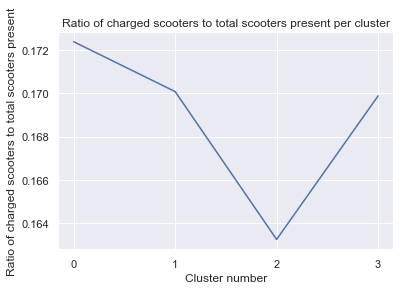

In [25]:
charged_scooters_per_cluster = data[data.power_level == 5][["scooter_id","cluster_number"]].groupby("cluster_number").count()
charged_scooters_per_cluster.reset_index(inplace=True)
charged_scooters_per_cluster.rename(columns= {"scooter_id": "count_of_charged_scooters"}, inplace=True)

total_and_charged_scooters = scooters_per_cluster.join(charged_scooters_per_cluster.set_index("cluster_number"), on="cluster_number")
total_and_charged_scooters['activity_indicator'] = total_and_charged_scooters.apply(lambda x: x['count_of_charged_scooters']/x['count_of_scooters'], axis=1)

plt.plot(total_and_charged_scooters['activity_indicator'])
plt.xticks(np.arange(0, n_clusters,1))
plt.xlabel("Cluster number")
plt.ylabel("Ratio of charged scooters to total scooters present")
plt.title("Ratio of charged scooters to total scooters present per cluster")

According to this definition, cluster 2 has the least amount of charged scooters, followed by 3, 2 and 1.

#### Conclusions:
According to various definitions of popularity, we have the following results:
- number of total scooters: Cluster 0
- ratio of discharged to total scooters: Cluster 1
- ratio of charged scooters to total scooters: Cluster 2

Without knowing the population density around the area, it is difficult to estimate which definition of popularity fits our case. Without knowing the population density, it is safe to assume the ratio of charged scooters to total scooters as a definition of popularity. The less the number of charged scooters in a location, the more scooters have been used from that location. So, cluster 2 is the most popular location.

<a id="operation-cost"></a>
### Operation cost

The bus starts from `(20.19, 20.19)` and moves at a speed of 50mph. It is assumed that ten unit distance on the graph is equivalent to one mile distance. Since Cluster 2 is the most popular location, it makes sense to try and charge the scooters at cluster 2 to start off. Then the bus would move to cluster 0, followed by cluster 1, cluster 3 before making its way back to its stop.

In [26]:
def euclidean_distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)

In [27]:
distance_from_bus_stop_to_cluster_2 = euclidean_distance(20.19, 20.19, -0.15658026, 0.01204397)/10
time_taken_to_reach_cluster_2 = distance_from_bus_stop_to_cluster_2/50

distance_from_cluster_2_to_cluster_0 = euclidean_distance(-0.15658026, 0.01204397, 0.2856132, -0.02145622)/10
time_taken_to_reach_cluster_0 = distance_from_cluster_2_to_cluster_0/50

distance_from_cluster_0_to_cluster_1 = euclidean_distance(0.2856132, -0.02145622, 0.98812503,0.77379981)/10
time_taken_to_reach_cluster_1 = distance_from_cluster_0_to_cluster_1/50

distance_from_cluster_1_to_cluster_3 = euclidean_distance(0.98812503,0.77379981, 0.88000396, 1.20009559)/10
time_taken_to_reach_cluster_3 = distance_from_cluster_1_to_cluster_3/50

distance_from_cluster_3_to_bus_stop = euclidean_distance(0.88000396, 1.20009559, 20.19, 20.19)/10
time_taken_to_reach_bus_stop = distance_from_cluster_3_to_bus_stop/50

In [28]:
time_taken_to_reach_cluster_2 + time_taken_to_reach_cluster_0 + time_taken_to_reach_cluster_1 + time_taken_to_reach_cluster_3 + time_taken_to_reach_bus_stop

3.1122833699843

Time spent in transit if the bus follows this order is around 3 hours, with the assumption that the bus moves with an average speed of 50mph.

From our previous estimate, the total time taken to charge is around 25 hours. So, the total time required would be around 28 hours.

<a id="final-conclusions"></a>
### Final conclusions:

#### Assumptions:
- Ten units distance on the map is equivalent to one mile.
- The bus travels at an average speed of 50mph.
- The rate of charging of a scooter is linear. With one hour of charge, the power level of a given scooter increases by one, if it is not already completely charged.
- The rate of discharging of a scooter is slower than charging. A power level of 2 means that the scooter won't discharge atleast before 2 hours of usage.
- A location is defined to be popular if the ratio of fully charged scooters to total number of available scooters is low. 
- A bus can hold 1000 scooters at once.
- The time taken to move from the center of the cluster to individual scooters is negligible compared to the other distances.
- The time taken to load and unload scooters has been ignored.
- It is possible that the bus picks up scooters from one cluster, and charges them while on the way to the second cluster, drops them there and picks up the discharged bikes from the second cluster and moves to the third cluster and so on. But since the transit time is minor as compared to the charging time, this possibility has been ignored.

#### Conclusions:
- The bus doesn't need to charge all the scooters. It can charge the scooters that have a power level below 2.
- It also doesn't need to charge the scooters all the way through. It can charge them halfway and try to service maximum consumers.
- Cluster 2 is the most popular with the definition of popularity assumed.
- The charging strategy to reduce operation cost and to maximise consumer gain would be to charge cluster 2 first, followed by cluster 0, then 1 and finally 3.
- The amount of time spent in total would be around 28 hours.